In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
data.drop("KyleLambda", axis=1, inplace=True, errors='ignore')

Số flash (1/ngày bận): 7 — days=['2025-10-10', '2025-10-03', '2025-10-05', '2025-09-25', '2025-10-07', '2025-10-09', '2025-09-22', '2025-10-01']


/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_17235/243333050.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


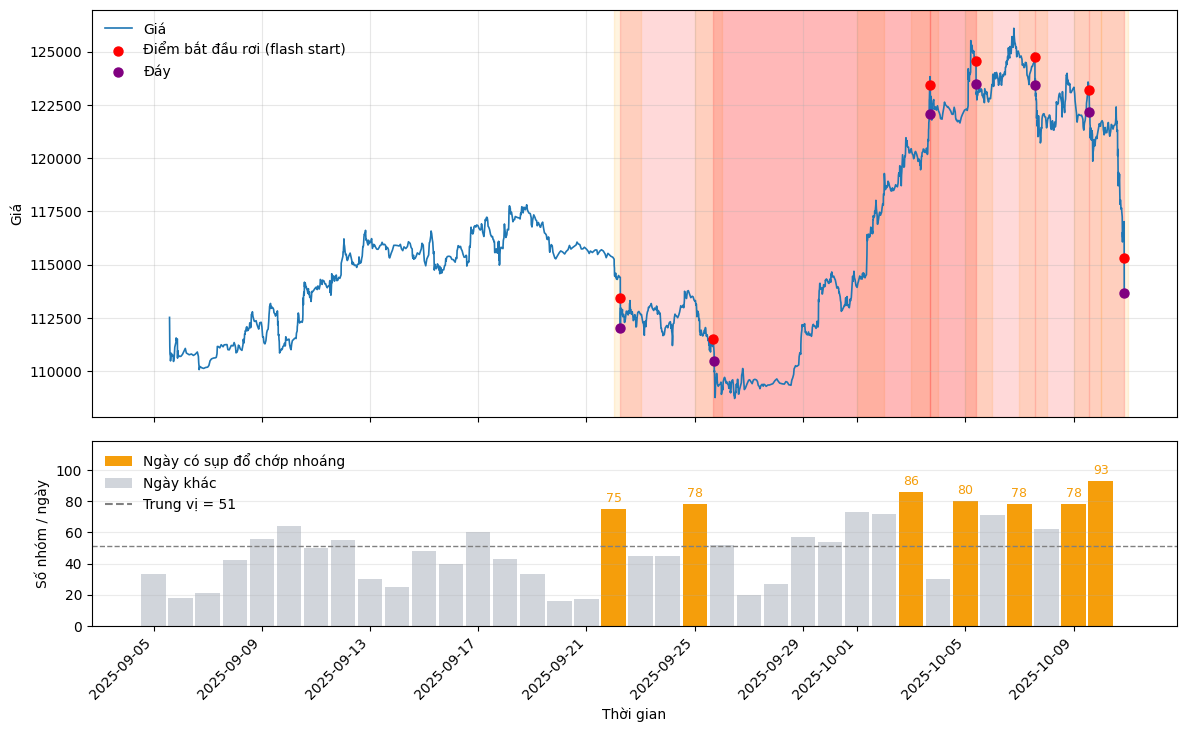

            buckets_per_day  window_hours_median  window_hours_min  window_hours_max
day                                                                                 
2025-09-05               33                  NaN               NaN               NaN
2025-09-06               18                31.09             30.27             31.91
2025-09-07               21                43.74             33.73             52.10
2025-09-08               42                44.59             32.57             56.42
2025-09-09               56                24.49             19.22             32.23
2025-09-10               64                20.41             13.58             23.31
2025-09-11               50                22.86             16.23             25.99
2025-09-12               55                21.16             18.84             25.34
2025-09-13               30                25.84             23.00             29.28
2025-09-14               25                41.33             30.8

In [4]:
# ===== INPUT =====
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

N = 50                 # độ dài cửa sổ VPIN (để tính "bucket clock")
m_fwd = 3              # số bucket nhìn tới để đo drawdown (start -> trough)
min_abs_drop = -0.008  # ngưỡng rơi tối thiểu để coi là flash (0.8%)
tz = df.index.tz

# ===== Buckets/day & "bucket clock" =====
per_day = (
    df.assign(day=(df.index.tz_convert(tz).date if tz else df.index.date))
      .groupby('day').size().rename('buckets_per_day')
)

idx = df.index
earlier_idx = idx.to_series().shift(N-1)
df['vp_window_hours'] = (idx.to_series() - earlier_idx).dt.total_seconds()/3600.0

# ===== Drawdown tương lai (dd_m) & trough =====
def forward_drawdown(s_price: pd.Series, m: int):
    fut = pd.concat([s_price.shift(-k) for k in range(1, m+1)], axis=1)
    fwd_min = fut.min(axis=1)
    dd_m = (fwd_min / s_price) - 1
    return dd_m, fut

dd_m, fut_matrix = forward_drawdown(df['Price'], m_fwd)

# ===== CHỌN 2 NGÀY "BẬN" NHẤT rồi lấy 1 flash sâu nhất/ngày
busy_days = per_day.sort_values(ascending=False).head(8).index  # kiểu date

starts, troughs = [], []
for d in busy_days:
    mask_day = (dd_m.index.tz_convert(tz).date == d) if tz else (dd_m.index.date == d)
    dd_day = dd_m[mask_day]
    if dd_day.empty:
        continue
    t_star = dd_day.idxmin()
    if np.isnan(dd_m.loc[t_star]) or dd_m.loc[t_star] > min_abs_drop:
        continue
    row = fut_matrix.loc[t_star].values
    j = int(np.nanargmin(row))  # 0..m_fwd-1
    trough_pos = df.index.get_loc(t_star) + (j+1)
    trough_pos = max(0, min(trough_pos, len(df.index)-1))
    t_trough = df.index[trough_pos]
    starts.append(t_star); troughs.append(t_trough)

starts = pd.DatetimeIndex(sorted(starts))
troughs = pd.DatetimeIndex([t for _, t in sorted(zip(starts, troughs))])
flash_days = {(t.tz_convert(tz).date if tz else t.date()) for t in starts}  # set ngày có flash

print(f"Số flash (1/ngày bận): {len(starts)} — days={list(map(str, busy_days))}")

# ===== VẼ =====
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 1, height_ratios=[2.2, 1], hspace=0.08)
ax_p = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[1, 0], sharex=ax_p)

# --- Panel trên: GIÁ + flash ---
ax_p.plot(df.index, df['Price'], label='Giá', linewidth=1.2)

# Tô nền 2 ngày bận
for d in busy_days:
    d0 = pd.Timestamp(d).tz_localize(tz) if tz else pd.Timestamp(d)
    d1 = d0 + pd.Timedelta(days=1)
    ax_p.axvspan(d0, d1, color='orange', alpha=0.12, zorder=0)

# Markers
if len(starts):
    ax_p.scatter(starts, df.loc[starts,'Price'], s=42, color='red',
                 label='Điểm bắt đầu rơi (flash start)', zorder=3)
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs,'Price'], s=42, color='purple',
                 label='Đáy', zorder=3)
for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax_p.axvspan(st, tr, alpha=0.15, color='red')

ax_p.set_ylabel('Giá')
ax_p.grid(alpha=.3)
ax_p.legend(loc='upper left', frameon=False)

# --- Panel dưới: SỐ BUCKET MỖI NGÀY (highlight ngày có flash) ---
# chuẩn hoá dải ngày & đưa về Timestamp (00:00) cùng tz
day_start = (df.index.min().tz_convert(tz).normalize() if tz else df.index.min().normalize())
day_end   = (df.index.max().tz_convert(tz).normalize() if tz else df.index.max().normalize())
all_days  = pd.date_range(day_start, day_end, freq='D')  # có thể đã tz-aware

# buckets/day đầy đủ theo dải ngày (index=DATE), và trục x dạng TIMESTAMP 00:00 cùng tz
per_day_ts = per_day.reindex(all_days.date).fillna(0)

if tz is not None:
    x_days = all_days if all_days.tz is not None else all_days.tz_localize(tz)
    if all_days.tz is not None and all_days.tz != tz:
        x_days = all_days.tz_convert(tz)
else:
    x_days = all_days

# tập ngày có flash (Timestamp 00:00 đúng tz)
flash_days_ts = pd.DatetimeIndex(sorted({
    (t.tz_convert(tz).normalize() if tz else t.normalize()) for t in starts
}))

# mask thanh nào là flash day
flash_mask = pd.Index(x_days).isin(flash_days_ts)

# màu rõ ràng
flash_color = '#f59e0b'   # cam
other_color = '#d1d5db'   # xám nhạt
bar_colors = np.where(flash_mask, flash_color, other_color)

# vẽ cột
bars = ax_b.bar(x_days, per_day_ts.values, color=bar_colors, width=0.9, align='center',
                edgecolor='none')

# đường trung vị
vals = per_day_ts.values.astype(float)
med_bpd = np.nanmedian(np.where(vals > 0, vals, np.nan))
if not np.isnan(med_bpd):
    ax_b.axhline(med_bpd, ls='--', lw=1.0, color='gray')
    med_label = f'Trung vị = {med_bpd:.0f}'
else:
    med_label = None

# Đặt ylim có “đầu” để số 88/90 không chạm khung
max_y = max(per_day_ts.max(), med_bpd if not np.isnan(med_bpd) else 0)
ax_b.set_ylim(0, max_y*1.28)  # thêm ~28% khoảng trống phía trên

# Ghi số trên các cột flash (đặt cao hơn median & cách đỉnh cột một khoảng)
base_offset = max(2, 0.03 * max_y)  # tối thiểu 2 đơn vị, hoặc 3% chiều cao
for xi, yi, is_flash in zip(x_days, per_day_ts.values, flash_mask):
    if is_flash and yi > 0:
        y_text = yi + base_offset
        if not np.isnan(med_bpd):
            y_text = max(y_text, med_bpd + base_offset)
        ax_b.text(xi, y_text, f'{int(yi)}', ha='center', va='bottom',
                  fontsize=9, color=flash_color, clip_on=False)

ax_b.set_ylabel('Số nhóm / ngày')
ax_b.grid(alpha=.25, axis='y')

from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=flash_color, edgecolor='none', label='Ngày có sụp đổ chớp nhoáng'),
    Patch(facecolor=other_color, edgecolor='none', label='Ngày khác'),
]
if med_label:
    legend_handles.append(plt.Line2D([0],[0], ls='--', color='gray', label=med_label))
ax_b.legend(handles=legend_handles, frameon=False, loc='upper left')

# Xoay nhãn trục X 45 độ để không chồng chéo (áp dụng cho panel dưới – panel trên sharex)
plt.setp(ax_b.get_xticklabels(), rotation=45, ha='right')
ax_p.tick_params(labelbottom=False)  # ẩn nhãn x ở panel trên

plt.xlabel('Thời gian')
plt.tight_layout()
plt.show()

# ===== BẢNG TÓM TẮT =====
summary = pd.DataFrame({'buckets_per_day': per_day}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).max(),
)
print(summary.round(2).to_string())


In [5]:
print("Min dd_m toàn bộ:", dd_m.min())
print("Số điểm dd_m <= -0.01:", (dd_m <= -0.01).sum())
print("Số điểm dd_m <= -0.008:", (dd_m <= -0.008).sum())


Min dd_m toàn bộ: -0.014241642626366069
Số điểm dd_m <= -0.01: 6
Số điểm dd_m <= -0.008: 25


In [6]:
# Gán 1 cho 3 bucket trước khi crash xảy ra (mô hình học được vùng nguy hiểm ngay TRƯỚC khi flash crash xảy ra.)
df["label"] = 0
lookback = 3

for st in starts:
    pos = df.index.get_loc(st)
    lb = max(0, pos - lookback)
    df.iloc[lb:pos+1, df.columns.get_loc("label")] = 1


In [7]:
df["label"].value_counts()

label
0    1799
1      28
Name: count, dtype: int64

In [8]:
original_features = [
    'Buy', 'Sell', 'Price', 'BidPrice', 'AskPrice', 'Volume', 'VPIN', 'CDF',
    'Roll', 'RollImpact', 'Returns', 'AmihudLambda',
    'BidAskSpread', 'SpreadChangeSign', 'RealizedVolatility',
    'RealizedVolatilitySign', 'ReturnsSign', 'Skewness', 'Kurtosis',
    'JB_rolling', 'JB_ChangeSign', 'AR', 'AR_ChangeSign', 'SkewnessSign',
    'KurtosisSign', 'MA_20', 'MA_50', 'MASign', 'vp_window_hours'
]


In [9]:
lag_features = []

for col in original_features:
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_lag2"] = df[col].shift(2)
    df[f"{col}_lag3"] = df[col].shift(3)
    
    lag_features += [f"{col}_lag1", f"{col}_lag2", f"{col}_lag3"]


In [10]:
df["ret"] = df["Price"].pct_change()
df["ret_lag1"] = df["ret"].shift(1)
df["ret_lag2"] = df["ret"].shift(2)
df["VPIN_slope"] = df["VPIN"].diff()
df["VPIN_slope2"] = df["VPIN"].rolling(3).mean().diff()
df = df.dropna().copy()
y = df["label"].astype(int)
exclude = ["label", "Price"] 
X = df.drop(columns=exclude)



In [11]:
print("X:", X.shape)
print("y:", y.shape)
print("Số mẫu label=1:", y.sum())
print("Số mẫu label=0:", (y==0).sum())


X: (1724, 120)
y: (1724,)
Số mẫu label=1: 28
Số mẫu label=0: 1696


In [12]:
# Split theo thời gian
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [14]:
# from sklearn.linear_model import LogisticRegression

# log_reg = LogisticRegression(
#     penalty="l2",
#     C=1.0,
#     max_iter=2000,
#     class_weight="balanced"   # cực kỳ quan trọng vì label rất hiếm
# )

# log_reg.fit(X_train_scaled, y_train)

# log_prob_train = log_reg.predict_proba(X_train_scaled)[:, 1]
# log_prob_test  = log_reg.predict_proba(X_test_scaled)[:, 1]


In [15]:
# from sklearn.ensemble import RandomForestClassifier

# # ----- Random Forest: baseline phi tuyến, không phụ thuộc xgboost -----
# rf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=4,
#     min_samples_leaf=5,
#     class_weight="balanced",   # rất quan trọng vì label=1 rất hiếm
#     random_state=42,
#     n_jobs=-1
# )

# rf.fit(X_train, y_train)

# rf_prob_train = rf.predict_proba(X_train)[:, 1]
# rf_prob_test  = rf.predict_proba(X_test)[:, 1]

# # Gán vào df để dùng sau (ensemble / vẽ alerts, v.v.)
# df.loc[X_train.index, "rf_prob"] = rf_prob_train
# df.loc[X_test.index,  "rf_prob"] = rf_prob_test

# # Xem nhanh performance (chỉ để tham khảo, vì threshold 0.5 không hợp lý lắm)
# from sklearn.metrics import classification_report

# print("Random Forest (thr=0.5):")
# print(classification_report(y_test, (rf_prob_test > 0.5).astype(int)))


In [16]:
# df.loc[X_train.index, "logreg_prob"] = log_prob_train
# df.loc[X_test.index,  "logreg_prob"] = log_prob_test

# df.loc[X_train.index, "xgb_prob"] = rf_prob_train
# df.loc[X_test.index,  "xgb_prob"] = rf_prob_test


In [17]:
# from sklearn.metrics import classification_report

# print("Logistic Regression:")
# print(classification_report(y_test, (log_prob_test > 0.5).astype(int)))

# print("XGBoost:")
# print(classification_report(y_test, (rf_prob_test > 0.5).astype(int)))


In [18]:
import numpy as np
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, log_prob_test)

# precision_recall_curve trả:
# - prec, rec: length = len(thr) + 1
# Nên ta dùng prec[:-1], rec[:-1] để align với thr
f2 = (5 * prec[:-1] * rec[:-1]) / (4 * prec[:-1] + rec[:-1] + 1e-9)

best_i = np.nanargmax(f2)
best_thr = thr[best_i]

print(f"Best threshold theo F2: {best_thr:.4f}")
print(f"Precision@best = {prec[best_i]:.3f}, Recall@best = {rec[best_i]:.3f}, F2 = {f2[best_i]:.3f}")


NameError: name 'log_prob_test' is not defined

In [ ]:
# df["prob_smooth"] = df["logreg_prob"].rolling(5, min_periods=1).mean()

In [ ]:
# y_prob = df["prob_smooth"].values
# times  = df.index
# best_thr = 0.0002           # threshold tìm được từ F2
# COOLDOWN = pd.Timedelta("45min")
# MATCH_WIN = pd.Timedelta("20min")    # match trong ±20m


In [ ]:
# alerts = []
# last = None

# for t, p in zip(times, y_prob):
#     if p >= best_thr:
#         if (last is None) or ((t - last) >= COOLDOWN):
#             alerts.append(t)
#             last = t


In [ ]:
# alerts = pd.DatetimeIndex(alerts)
# print("Số ALERT:", len(alerts))


In [ ]:
# tp = fp = 0
# matched = set()

# for a in alerts:
#     # Tìm flash start gần nhất trong ± MATCH_WIN
#     cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
#     if cand:
#         s0 = min(cand, key=lambda x: abs(a - x))
#         matched.add(s0)
#         tp += 1
#     else:
#         fp += 1

# fn = len(starts) - tp



In [ ]:
# precision = tp / (tp + fp + 1e-9)
# recall    = tp / (tp + fn + 1e-9)

# print(f"TP={tp}, FP={fp}, FN={fn}")
# print(f"Event-level precision={precision:.3f}")
# print(f"Event-level recall   ={recall:.3f}")


In [ ]:
# fig, ax = plt.subplots(figsize=(14,6))

# ax.plot(df.index, df["Price"], label="Price", linewidth=1.0)

# # Flash start/trough từ detection code
# ax.scatter(starts, df.loc[starts, "Price"], color="red",  s=40, label="Flash Start")
# ax.scatter(troughs, df.loc[troughs,"Price"], color="purple", s=40, label="Flash Trough")

# # Alerts từ model
# ax.scatter(alerts, df.loc[alerts, "Price"], color="orange", s=45, marker="^",
#            label="Model Alert", zorder=4)

# ax.set_ylabel("Price")
# ax.grid(alpha=0.3)
# ax.legend()
# plt.title("Flash Crash Prediction Alerts (Logistic Regression)")
# plt.show()


#### ĐOẠN MỚI

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    solver="lbfgs"
)

logreg.fit(X_train, y_train)


In [ ]:
df["p_raw"] = logreg.predict_proba(X)[:,1]
df["p_smooth"] = df["p_raw"].rolling(5, min_periods=1).mean()


In [ ]:
# df["weak_price"] = df["Returns"] < 0


In [ ]:
# df["high_vpin"] = df["VPIN"] >= 0.85


In [ ]:
# df["wide_spread"] = df["BidAskSpread"] >= df["BidAskSpread"].median()


In [ ]:
BEST_THR = best_thr   # = 0.0002 của bạn
COOLDOWN = pd.Timedelta("45min")

alerts = []
last_alert = None

for t, row in df.iterrows():
    cond_prob  = row["p_smooth"] >= BEST_THR
    cond_ret   = row["weak_price"]
    cond_vpin  = row["high_vpin"]
    cond_sp    = row["wide_spread"]
    
    # Multi-condition filter
    must_alert = cond_prob and (cond_ret + cond_vpin + cond_sp >= 2)

    if must_alert:
        if last_alert is None or (t - last_alert) >= COOLDOWN:
            alerts.append(t)
            last_alert = t

alerts = pd.DatetimeIndex(alerts)
print("Số ALERT sau filter:", len(alerts))


### FILTER THÊM

In [ ]:
# import numpy as np
# import pandas as pd

# ALERTS_PER_DAY = 10                    # ví dụ: muốn ~10 alert/ngày
# COOLDOWN = pd.Timedelta("45min")       # cooldown mạnh hơn 45'
# BEST_THR_BASE = best_thr               # = 0.0002 của bạn


In [ ]:
# vpin_thr = df["VPIN"].quantile(0.8)   # top 20% VPIN cao nhất
# print("VPIN threshold:", vpin_thr)

In [ ]:
# vpin_thr = df["VPIN"].quantile(0.8)   # hoặc 0.75, 0.9 tùy bạn

# def alerts_per_day(thr):
#     last = None
#     counts = {}

#     for t, row in df.iterrows():
#         p  = row["p_smooth"]
#         ret = row["Returns"]
#         vpin = row["VPIN"]

#         cond_prob = (p >= thr)
#         cond_ret  = (ret < 0)
#         cond_vpin = (vpin >= vpin_thr)

#         if cond_prob and cond_ret and cond_vpin:
#             if (last is None) or (t - last >= COOLDOWN):
#                 d = t.date()
#                 counts[d] = counts.get(d, 0) + 1
#                 last = t

#     return np.mean(list(counts.values())) if counts else 0.0


In [ ]:
# vpin_thr = df["VPIN"].quantile(0.8)   # hoặc 0.75, 0.9 tùy bạn

# def alerts_per_day(thr):
#     last = None
#     counts = {}

#     for t, row in df.iterrows():
#         p  = row["p_smooth"]
#         ret = row["Returns"]
#         vpin = row["VPIN"]

#         cond_prob = (p >= thr)
#         cond_ret  = (ret < 0)
#         cond_vpin = (vpin >= vpin_thr)

#         if cond_prob and cond_ret and cond_vpin:
#             if (last is None) or (t - last >= COOLDOWN):
#                 d = t.date()
#                 counts[d] = counts.get(d, 0) + 1
#                 last = t

#     return np.mean(list(counts.values())) if counts else 0.0


In [ ]:
# grid = np.linspace(BEST_THR_BASE, 0.01, 60)

# best_thr_budget = min(grid, key=lambda g: abs(alerts_per_day(g) - ALERTS_PER_DAY))

# print(f"Threshold theo alert-budget: {best_thr_budget:.6f}, "
#       f"alerts/ngày ≈ {alerts_per_day(best_thr_budget):.2f}")


In [ ]:
# alerts = []
# last = None

# for t, row in df.iterrows():
#     p  = row["p_smooth"]
#     ret = row["Returns"]
#     vpin = row["VPIN"]

#     cond_prob = (p >= best_thr_budget)
#     cond_ret  = (ret < 0)
#     cond_vpin = (vpin >= vpin_thr)

#     if cond_prob and cond_ret and cond_vpin:
#         if (last is None) or (t - last >= COOLDOWN):
#             alerts.append(t)
#             last = t

# alerts = pd.DatetimeIndex(alerts)
# print("Số ALERT sau alert-budget:", len(alerts))


In [ ]:
# tp = fp = 0
# matched = set()

# for a in alerts:
#     cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
#     if cand:
#         s0 = min(cand, key=lambda x: abs(a - x))
#         matched.add(s0)
#         tp += 1
#     else:
#         fp += 1

# fn = len(starts) - tp

# precision = tp / (tp + fp + 1e-9)
# recall    = tp / (tp + fn + 1e-9)

# print(f"TP={tp}, FP={fp}, FN={fn}")
# print(f"Event-level precision={precision:.3f}")
# print(f"Event-level recall   ={recall:.3f}")


In [ ]:
# vpin_thr = df["VPIN"].quantile(0.8)   # dùng lại top 20%, đừng dùng 90%

# alerts = []
# last = None

# for t, row in df.iterrows():
#     p     = row["p_smooth"]
#     ret   = row["Returns"]
#     vpin  = row["VPIN"]

#     cond_prob = (p >= best_thr_budget)
#     cond_ret  = (ret < 0)
#     cond_vpin = (vpin >= vpin_thr)

#     # --- Soft logic: tăng recall ---
#     must_alert = cond_prob and (cond_ret or cond_vpin)

#     if must_alert:
#         if (last is None) or (t - last >= COOLDOWN):
#             alerts.append(t)
#             last = t

# alerts = pd.DatetimeIndex(alerts)
# print("Số ALERT sau soft-filter:", len(alerts))


In [ ]:
# vpin_thr   = df["VPIN"].quantile(0.80)     # Top 20% VPIN
# spread_thr = df["BidAskSpread"].quantile(0.70)  # Top 30% Spread
# vol_thr    = df["RealizedVolatility"].quantile(0.80)  # Top 20% Volatility

# print("VPIN:", vpin_thr, "Spread:", spread_thr, "Vol:", vol_thr)


In [ ]:
# # ============================
# # 1) THRESHOLD & NGƯỠNG STRESS
# # ============================

# thr = best_thr_budget     # threshold từ alert-budget
# COOLDOWN = pd.Timedelta("45min")
# MATCH_WIN = pd.Timedelta("20min")

# # Ngưỡng stress theo quantile
# vpin_thr   = df["VPIN"].quantile(0.80)                 # top 20%
# spread_thr = df["BidAskSpread"].quantile(0.70)         # top 30%
# vol_thr    = df["RealizedVolatility"].quantile(0.80)   # top 20%

# print("VPIN_thr:", vpin_thr)
# print("Spread_thr:", spread_thr)
# print("Vol_thr:", vol_thr)


# # ============================
# # 2) VECTORIZED CONDITIONS
# # ============================

# # Stage 1 – prob high
# cond_prob = df["p_smooth"] >= thr

# # Stage 3 – price weakening
# cond_price = df["Returns"] < 0

# # Stage 2 – stress detection
# stress_count = (
#     (df["VPIN"] >= vpin_thr).astype(int)
#     + (df["BidAskSpread"] >= spread_thr).astype(int)
#     + (df["RealizedVolatility"] >= vol_thr).astype(int)
# )
# cond_stress = stress_count >= 1      # ít nhất 1 stress spike

# # Final 3-stage mask
# mask = cond_prob & cond_price & cond_stress

# print("Số điểm thoả điều kiện (trước cooldown):", mask.sum())


# # ============================
# # 3) APPLY COOLDOWN
# # ============================

# alerts = []
# last = None

# for t in df.index[mask]:
#     if (last is None) or (t - last >= COOLDOWN):
#         alerts.append(t)
#         last = t

# alerts = pd.DatetimeIndex(alerts)
# print("Số ALERT:", len(alerts))


# # ============================
# # 4) EVENT-LEVEL EVALUATION
# # ============================

# tp = fp = 0
# matched = set()

# for a in alerts:
#     cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
#     if cand:
#         s0 = min(cand, key=lambda x: abs(a - x))
#         matched.add(s0)
#         tp += 1
#     else:
#         fp += 1

# fn = len(starts) - tp

# precision = tp / (tp + fp + 1e-9)
# recall    = tp / (tp + fn + 1e-9)

# print(f"TP={tp}, FP={fp}, FN={fn}")
# print(f"Event-level precision={precision:.3f}")
# print(f"Event-level recall   ={recall:.3f}")


In [ ]:
# import numpy as np
# import pandas as pd

# # ========= CONFIG =========
# ALERTS_PER_DAY = 10                 # mục tiêu cảnh báo trung bình / ngày
# COOLDOWN = pd.Timedelta("15min")
# MATCH_WIN = pd.Timedelta("20min")   # match event trong ±20 phút
# # ==========================

# # 1) Hàm tính số alerts/ngày cho 1 threshold
# def alerts_per_day(thr):
#     last = None
#     counts = {}

#     for t, p in zip(df.index, df["p_smooth"].values):
#         if p >= thr:
#             if (last is None) or (t - last >= COOLDOWN):
#                 d = t.date()
#                 counts[d] = counts.get(d, 0) + 1
#                 last = t

#     return np.mean(list(counts.values())) if counts else 0.0

# # 2) Quét threshold để đạt ALERTS_PER_DAY
# grid = np.linspace(0.0001, 0.01, 60)
# best_thr = min(grid, key=lambda g: abs(alerts_per_day(g) - ALERTS_PER_DAY))

# print(f"[Alert budget] chọn threshold ≈ {best_thr:.6f} (~{ALERTS_PER_DAY} cảnh báo/ngày)")
# print("alerts/ngày thực tế ≈", alerts_per_day(best_thr))

# # 3) Sinh danh sách ALERT với threshold + cooldown
# alerts = []
# last = None

# for t, p in zip(df.index, df["p_smooth"].values):
#     if p >= best_thr:
#         if (last is None) or (t - last >= COOLDOWN):
#             alerts.append(t)
#             last = t

# alerts = pd.DatetimeIndex(alerts)
# print("Tổng số ALERT:", len(alerts))

# # 4) Đánh giá event-level (so với starts)
# tp = fp = 0
# matched = set()

# for a in alerts:
#     cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
#     if cand:
#         s0 = min(cand, key=lambda x: abs(a - x))
#         matched.add(s0)
#         tp += 1
#     else:
#         fp += 1

# fn = len(starts) - tp

# precision_ev = tp / (tp + fp + 1e-9)
# recall_ev    = tp / (tp + fn + 1e-9)

# print(f"TP={tp}, FP={fp}, FN={fn}")
# print(f"Event-level precision={precision_ev:.3f}")
# print(f"Event-level recall   ={recall_ev:.3f}")


In [ ]:
# print(df["p_smooth"].describe())


In [ ]:
# # 1) Xem phân phối p_smooth thật
# print(df["p_smooth"].describe())

# # 2) Tạo dải threshold hợp lý dựa trên quantile
# low_thr  = df["p_smooth"].quantile(0.90)     # top 10%
# high_thr = df["p_smooth"].quantile(0.999)    # top 0.1%

# print("Scan range =", low_thr, "->", high_thr)

# grid = np.linspace(low_thr, high_thr, 60)

# # 3) Alert budget function
# def alerts_per_day(thr):
#     last = None
#     counts = {}
#     for t, p in zip(df.index, df["p_smooth"].values):
#         if p >= thr:
#             if last is None or (t - last >= COOLDOWN):
#                 d = t.date()
#                 counts[d] = counts.get(d, 0) + 1
#                 last = t
#     return np.mean(list(counts.values())) if counts else 0.0

# # 4) Tìm threshold
# best_thr = min(grid, key=lambda g: abs(alerts_per_day(g) - ALERTS_PER_DAY))
# print("[Alert budget] threshold =", best_thr)
# print("alerts/ngày thực tế:", alerts_per_day(best_thr))

# # 5) Lấy ALERT với cooldown
# alerts = []
# last = None
# for t, p in zip(df.index, df["p_smooth"].values):
#     if p >= best_thr:
#         if last is None or (t - last >= COOLDOWN):
#             alerts.append(t)
#             last = t

# alerts = pd.DatetimeIndex(alerts)
# print("Số ALERT:", len(alerts))


# FULL RANDOMFOREST

In [ ]:
import numpy as np
import pandas as pd

# ==== 1. Lấy các quantile của p_smooth ====
print(df["p_smooth"].describe())

q90  = float(df["p_smooth"].quantile(0.90))   # top 10%
q999 = float(df["p_smooth"].quantile(0.999))  # top 0.1%

print("q90  =", q90)
print("q999 =", q999)

# Phòng trường hợp q90 == q999 (dải quá hẹp)
if q90 == q999:
    q999 = float(df["p_smooth"].max())

# ==== 2. Tạo dải threshold để thử ====
thresholds = np.linspace(q90, q999, 40)

print("Scan range =", thresholds[0], "->", thresholds[-1])

results = []

for thr_try in thresholds:
    # 2.1 – tạo alerts với cooldown
    alerts_try = []
    last = None

    for t, p in zip(df.index, df["p_smooth"].values):
        if p >= thr_try:
            if (last is None) or (t - last >= COOLDOWN):
                alerts_try.append(t)
                last = t

    alerts_try = pd.DatetimeIndex(alerts_try)

    # 2.2 – match event-level với starts
    tp = fp = 0
    matched = set()

    for a in alerts_try:
        cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
        if cand:
            s0 = min(cand, key=lambda x: abs(a - x))
            matched.add(s0)
            tp += 1
        else:
            fp += 1

    fn = len(starts) - tp

    prec_ev = tp / (tp + fp + 1e-9)
    rec_ev  = tp / (tp + fn + 1e-9)

    # Event-level F2 (ưu tiên recall)
    if prec_ev + rec_ev > 0:
        f2 = (5 * prec_ev * rec_ev) / (4 * prec_ev + rec_ev + 1e-9)
    else:
        f2 = 0.0

    results.append([
        thr_try, len(alerts_try), tp, fp, fn, prec_ev, rec_ev, f2
    ])

# ==== 3. Kết quả ====
res_df = pd.DataFrame(results, columns=[
    "threshold", "n_alerts", "tp", "fp", "fn", "precision", "recall", "f2"
])

# Top 10 threshold tốt nhất theo F2
print(res_df.sort_values("f2", ascending=False).head(10))


KeyError: 'p_smooth'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# =========================================
# 0. CONFIG CHUNG
# =========================================
COOLDOWN  = pd.Timedelta("15min")   # cooldown giữa 2 alert
MATCH_WIN = pd.Timedelta("20min")   # match flash trong ±20 phút
TEST_SIZE = 0.2                     # 20% cuối làm test

# =========================================
# 1. CHUẨN BỊ DỮ LIỆU CHO RANDOM FOREST
# =========================================
# Giữ lại toàn bộ feature trừ 'label'
# feature_cols = [c for c in df.columns if c != "label"]
drop_cols = [
    "label",
    "rf_prob", "logreg_prob", "xgb_prob",
    "prob_smooth", "p_raw", "p_smooth",
    "weak_price", "high_vpin", "wide_spread",
]

feature_cols = [c for c in df.columns if c not in drop_cols]
print("Số feature:", len(feature_cols))
print("Feature:", feature_cols)

X = df[feature_cols].values
y = df["label"].values
times = df.index

print("X:", X.shape)
print("y:", y.shape, "— số label=1:", y.sum(), "số label=0:", (y == 0).sum())

# Train/test split theo thời gian (không shuffle)
n = len(df)
split_idx = int((1 - TEST_SIZE) * n)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
t_train, t_test = times[:split_idx], times[split_idx:]

print("Train size:", X_train.shape[0], "— Test size:", X_test.shape[0])

# =========================================
# 2. TRAIN RANDOM FOREST (CÓ CÂN BẰNG LỚP)
# =========================================
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_leaf=5,
    class_weight="balanced",  # RẤT QUAN TRỌNG cho rare event
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Đánh giá nhanh ở mức bucket với threshold 0.5 (chỉ để tham khảo)
y_prob_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== Random Forest – bucket-level (thr=0.5, chỉ để tham khảo) ===")
print(classification_report(y_test, y_pred_test))

# =========================================
# 3. LẤY XÁC SUẤT CHO TOÀN BỘ df + SMOOTHING
# =========================================
rf_prob_full = rf.predict_proba(X)[:, 1]
df["rf_prob"]   = rf_prob_full
df["p_smooth"]  = df["rf_prob"].rolling(5, min_periods=1).mean()  # smooth 5 bucket

print("\nMô tả phân phối p_smooth:")
print(df["p_smooth"].describe())

# =========================================
# 4. HÀM TẠO ALERT + HÀM ĐÁNH GIÁ 1 NGƯỠNG
# =========================================
def gen_alerts_from_thr(thr: float) -> pd.DatetimeIndex:
    """Sinh danh sách alert với threshold + cooldown."""
    alerts = []
    last = None
    for t, p in zip(df.index, df["p_smooth"].values):
        if p >= thr:
            if (last is None) or (t - last >= COOLDOWN):
                alerts.append(t)
                last = t
    return pd.DatetimeIndex(alerts)

def eval_threshold(thr: float):
    """Đánh giá 1 threshold ở mức event-level + alerts/day."""
    alerts = gen_alerts_from_thr(thr)

    # alerts/ngày
    if len(alerts):
        days = alerts.normalize()
        counts = pd.Series(1, index=days).groupby(level=0).size()
        alerts_per_day = counts.mean()
    else:
        alerts_per_day = 0.0

    # match với flash crash (starts)
    tp = fp = 0
    matched = set()
    for a in alerts:
        cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
        if cand:
            s0 = min(cand, key=lambda x: abs(a - x))
            matched.add(s0)
            tp += 1
        else:
            fp += 1

    fn = len(starts) - tp
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f2   = (5 * prec * rec) / (4 * prec + rec + 1e-9) if (prec + rec) > 0 else 0.0

    return {
        "thr": thr,
        "n_alerts": len(alerts),
        "alerts_per_day": alerts_per_day,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": prec,
        "recall": rec,
        "f2": f2,
        "alerts": alerts,
    }

# =========================================
# 5. QUÉT NGƯỠNG (DỰA TRÊN QUANTILE CỦA p_smooth)
#    → CHỌN NGƯỠNG TỐI ƯU F2 (ƯU TIÊN RECALL)
# =========================================
q90  = float(df["p_smooth"].quantile(0.90))   # top 10% prob
q999 = float(df["p_smooth"].quantile(0.999))  # top 0.1% prob
if q90 == q999:
    q999 = float(df["p_smooth"].max())

thresholds = np.linspace(q90, q999, 40)
print(f"\nScan threshold range: {thresholds[0]:.6f} → {thresholds[-1]:.6f}")

rows = []
best = None

for thr in thresholds:
    res = eval_threshold(thr)
    rows.append(res)
    if (best is None) or (res["f2"] > best["f2"]):
        best = res

res_df = pd.DataFrame(rows)
print("\n== TOP 10 NGƯỠNG TỐT NHẤT THEO EVENT-LEVEL F2 (ưu tiên recall) ==")
print(
    res_df.sort_values("f2", ascending=False)[
        ["thr", "n_alerts", "alerts_per_day", "tp", "fp", "fn", "precision", "recall", "f2"]
    ].head(10)
)

print("\n== NGƯỠNG ĐƯỢC CHỌN (best theo F2) ==")
print(f"Threshold = {best['thr']:.6f}")
print(f"Số ALERT  = {best['n_alerts']} (≈ {best['alerts_per_day']:.2f} alerts/ngày)")
print(f"TP={best['tp']}, FP={best['fp']}, FN={best['fn']}")
print(f"Event-level precision = {best['precision']:.3f}")
print(f"Event-level recall    = {best['recall']:.3f}")
print(f"Event-level F2        = {best['f2']:.3f}")

# Lưu ALERT cuối cùng
final_alerts = best["alerts"]


Số feature: 121
Feature: ['Buy', 'Sell', 'Price', 'BidPrice', 'AskPrice', 'Volume', 'VPIN', 'CDF', 'Roll', 'RollImpact', 'Returns', 'AmihudLambda', 'BidAskSpread', 'SpreadChangeSign', 'RealizedVolatility', 'RealizedVolatilitySign', 'ReturnsSign', 'Skewness', 'Kurtosis', 'JB_rolling', 'JB_ChangeSign', 'AR', 'AR_ChangeSign', 'SkewnessSign', 'KurtosisSign', 'MA_20', 'MA_50', 'MASign', 'vp_window_hours', 'Buy_lag1', 'Buy_lag2', 'Buy_lag3', 'Sell_lag1', 'Sell_lag2', 'Sell_lag3', 'Price_lag1', 'Price_lag2', 'Price_lag3', 'BidPrice_lag1', 'BidPrice_lag2', 'BidPrice_lag3', 'AskPrice_lag1', 'AskPrice_lag2', 'AskPrice_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'VPIN_lag1', 'VPIN_lag2', 'VPIN_lag3', 'CDF_lag1', 'CDF_lag2', 'CDF_lag3', 'Roll_lag1', 'Roll_lag2', 'Roll_lag3', 'RollImpact_lag1', 'RollImpact_lag2', 'RollImpact_lag3', 'Returns_lag1', 'Returns_lag2', 'Returns_lag3', 'AmihudLambda_lag1', 'AmihudLambda_lag2', 'AmihudLambda_lag3', 'BidAskSpread_lag1', 'BidAskSpread_lag2', 'BidAskS

/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hoapham/Documents/Learning/thesis/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_12746/1631818549.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


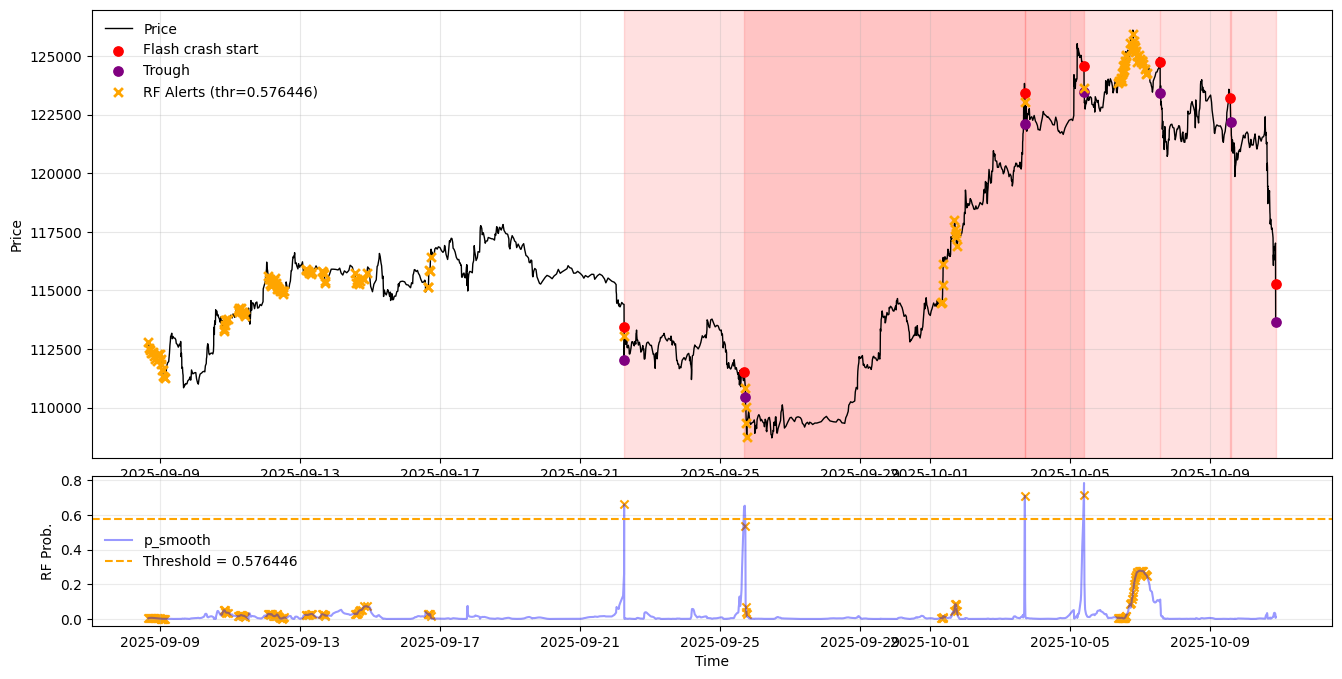

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# df.index = timestamps
# df["Price"]
# starts = flash crash start points
# troughs = flash crash troughs
# alerts = alert timestamps từ RF threshold

fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.06)

ax_p = fig.add_subplot(gs[0,0])
ax_a = fig.add_subplot(gs[1,0], sharex=ax_p)

# ============================
# PANEL 1 – PRICE + FLASH CRASH + ALERTS
# ============================
ax_p.plot(df.index, df["Price"], color="black", label="Price", linewidth=1)

# Flash crash start
if len(starts):
    ax_p.scatter(starts, df.loc[starts, "Price"], 
                 color="red", s=45, label="Flash crash start", zorder=3)

# Flash crash trough
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs, "Price"], 
                 color="purple", s=45, label="Trough", zorder=3)

# Shade the drop duration
for st, tr in zip(starts, troughs):
    if tr >= st:
        ax_p.axvspan(st, tr, color="red", alpha=0.12)

# RF ALERTS
if len(alerts):
    ax_p.scatter(alerts, df.loc[alerts, "Price"], 
                 color="orange", s=40, marker="x", linewidths=2,
                 label="RF Alerts (thr=0.576446)", zorder=4)

ax_p.set_ylabel("Price")
ax_p.legend(loc="upper left", frameon=False)
ax_p.grid(alpha=0.3)


# ============================
# PANEL 2 – ALERTS OVER TIME
# ============================
ax_a.plot(df.index, df["p_smooth"], color="blue", alpha=0.4, label="p_smooth")
ax_a.axhline(0.576446, color="orange", linestyle="--",
             label="Threshold = 0.576446")

# đánh dấu alert
if len(alerts):
    ax_a.scatter(alerts, df.loc[alerts, "p_smooth"], 
                 color="orange", marker="x", s=35)

ax_a.set_ylabel("RF Prob.")
ax_a.set_xlabel("Time")
ax_a.grid(alpha=0.25)
ax_a.legend(frameon=False)

plt.tight_layout()
plt.show()


/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_12746/1746404293.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


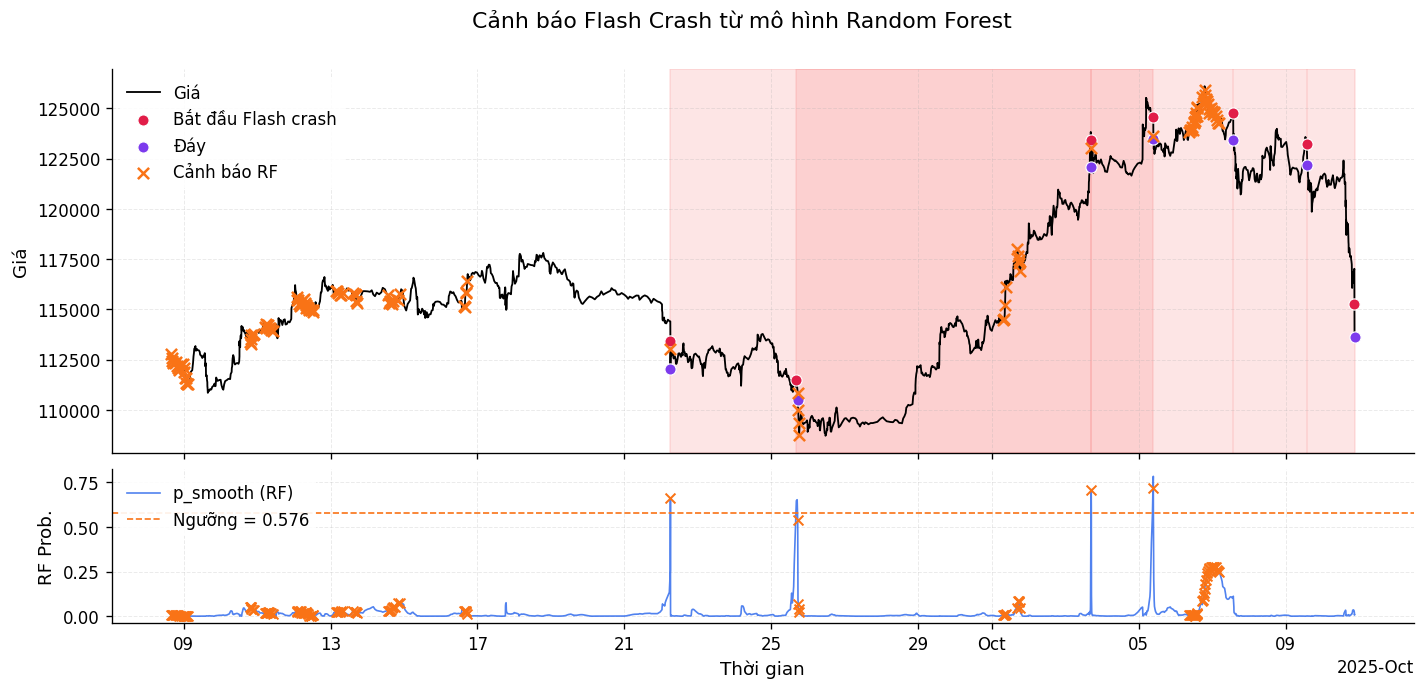

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# =========================
# CONFIG CHUNG CHO HÌNH
# =========================
plt.style.use("default")
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

rf_thr = 0.576446   # ngưỡng RF đã chọn
price_col = "Price"
prob_col  = "p_smooth"

fig = plt.figure(figsize=(14, 6), dpi=120)
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1.2], hspace=0.06)

ax_price = fig.add_subplot(gs[0, 0])
ax_prob  = fig.add_subplot(gs[1, 0], sharex=ax_price)

# =========================
# PANEL 1: PRICE + FLASH + ALERT
# =========================
# Đường giá
ax_price.plot(
    df.index, df[price_col],
    color="black", linewidth=1.1, label="Giá"
)

# Flash start & trough
if len(starts):
    ax_price.scatter(
        starts, df.loc[starts, price_col],
        s=45, color="#e11d48", edgecolor="white", linewidths=0.7,
        zorder=4, label="Bắt đầu Flash crash"
    )
if len(troughs):
    ax_price.scatter(
        troughs, df.loc[troughs, price_col],
        s=45, color="#7c3aed", edgecolor="white", linewidths=0.7,
        zorder=4, label="Đáy"
    )

# Tô nền vùng start -> trough
for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax_price.axvspan(
            st, tr,
            color="#f97373", alpha=0.18, zorder=0
        )

# RF ALERTS
if len(alerts):
    ax_price.scatter(
        alerts, df.loc[alerts, price_col],
        marker="x", s=45,
        color="#f97316", linewidths=1.5,
        zorder=5, label="Cảnh báo RF"
    )

ax_price.set_ylabel("Giá")
ax_price.grid(alpha=0.25, linestyle="--", linewidth=0.6)

# bỏ nhãn x ở panel trên để không rối
ax_price.tick_params(labelbottom=False)

# Legend đặt góc trên trái, không che dữ liệu
ax_price.legend(
    loc="upper left",
    frameon=True,
    framealpha=0.9,
    fancybox=True,
    edgecolor="none"
)

# =========================
# PANEL 2: p_smooth + THRESHOLD + ALERT
# =========================
ax_prob.plot(
    df.index, df[prob_col],
    color="#2563eb", linewidth=1.0, alpha=0.8,
    label="p_smooth (RF)"
)

ax_prob.axhline(
    rf_thr, color="#f97316", linestyle="--", linewidth=1.0,
    label=f"Ngưỡng = {rf_thr:.3f}"
)

# đánh dấu các alert
if len(alerts):
    ax_prob.scatter(
        alerts, df.loc[alerts, prob_col],
        marker="x", s=35,
        color="#f97316", linewidths=1.2,
        zorder=5
    )

ax_prob.set_ylabel("RF Prob.")
ax_prob.set_xlabel("Thời gian")
ax_prob.grid(alpha=0.25, linestyle="--", linewidth=0.6)
ax_prob.legend(
    loc="upper left",
    frameon=True,
    framealpha=0.9,
    fancybox=True,
    edgecolor="none"
)

# =========================
# FORMAT TRỤC THỜI GIAN
# =========================
locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax_prob.xaxis.set_major_locator(locator)
ax_prob.xaxis.set_major_formatter(formatter)

# nhẹ nhàng hoá spines
for ax in (ax_price, ax_prob):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Cảnh báo Flash Crash từ mô hình Random Forest", y=0.96)
plt.tight_layout()
plt.show()
